In [60]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

### Paths

In [61]:
#File paths
main_path_energy ='../data_base/paths_energy/'
main_path_total_energy = '../data_base/paths_totals/'

energy_path11_pd = pd.read_csv(main_path_energy + 'feat_pathv11_TM.csv')
energy_path12_pd = pd.read_csv(main_path_energy + 'feat_pathv12_TM.csv')
energy_path13_pd = pd.read_csv(main_path_energy + 'feat_pathv13_TM.csv')

energy_path_list = [energy_path11_pd,energy_path12_pd,energy_path13_pd]
complete_energy_pd = pd.concat(energy_path_list)

total_path11_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv11.csv')
total_path12_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv12.csv')
total_path13_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv13.csv')

total_path_list = [total_path11_pd,total_path12_pd,total_path13_pd]
complete_total_pd = pd.concat(total_path_list)

### Data split and preprocessing - complete_energy_pd - All data

this data comes from the folder "paths_energy"

In [62]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()

X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (3740, 935)


### Model - Neural network - relu and linear

In [63]:
NN_model = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model.add(Dense(64,kernel_initializer=ran_initial,input_dim=8,activation='relu'))

NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_55 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 58,561
Trainable params: 58,561
Non-trainable params: 0
__________________________________________________

In [64]:
start_time = time.time()
model1 = NN_model.fit(x_train, y_train, epochs=300, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


Execution time = 53.49881291389465


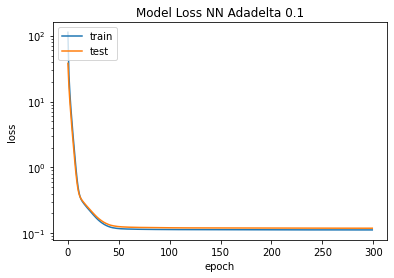

In [65]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Model Loss NN Adadelta 0.1')
plt.savefig('ModelLoss_Adadelta.png')
plt.show()

In [66]:
y_predict = NN_model.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

NN_model.save('NN_Adadelta.h5')

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.6237908096892334
RMSE: 1108388.3230830592
MSE: 1228524674746.876


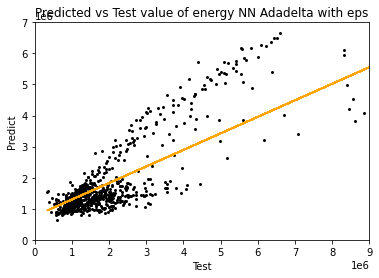

In [67]:
plt.scatter(y_test, y_predict,linewidths=0.01,c='black',marker='.')
plt.xlabel('Test')
plt.ylabel('Predict')
m, b = np.polyfit(y_test, y_predict, 1)

plt.plot(y_test, m*y_test + b, color='orange')
plt.title('Predicted vs Test value of energy NN Adadelta with eps')
plt.xlabel('Test')
plt.ylabel('Predict')
plt.xlim([0, 0.9e7])
plt.ylim([0, 0.7e7])
plt.savefig('predictvtest_NN_Adadelta.png')

### Data split and preprocessing - complete_energy_pd - with eps

In [68]:
eps = 5
complete_energy_pd = complete_energy_pd[(complete_energy_pd['sim_point_dist']-complete_energy_pd['teo_point_dist']) < eps]
print(f'new shape of complete_energy_pd = {complete_energy_pd.shape}')

new shape of complete_energy_pd = (3957, 17)


In [69]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()
x2 = X
X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler2 = StandardScaler()

x_train = scaler2.fit_transform(x_train)
x_test = scaler2.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (3165, 792)


In [70]:
NN_model11 = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model11.add(Dense(64,kernel_initializer=ran_initial,input_dim=8,activation='relu'))

NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model11.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model11.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.2), metrics=["mean_squared_logarithmic_error"])

In [71]:
start_time = time.time()
model11 = NN_model11.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


Execution time = 16.537081003189087


In [72]:
y_predict = NN_model11.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

NN_model11.save('NN_Adadelta_eps.h5')

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.6348789358239562
RMSE: 912708.3701615956
MSE: 833036568963.0363


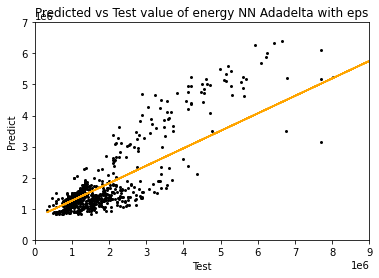

In [73]:

plt.scatter(y_test, y_predict,linewidths=0.01,c='black',marker='.')
plt.xlabel('Test')
plt.ylabel('Predict')
m, b = np.polyfit(y_test, y_predict, 1)

plt.plot(y_test, m*y_test + b, color='orange')
plt.title('Predicted vs Test value of energy NN Adadelta with eps')
plt.xlabel('Test')
plt.ylabel('Predict')
plt.xlim([0, 0.9e7])
plt.ylim([0, 0.7e7])
plt.savefig('predictvtest_NN_Adadelta_eps.png')

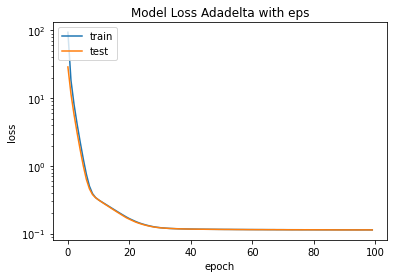

In [74]:
plt.plot(model11.history['loss'])
plt.plot(model11.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Model Loss Adadelta with eps')
plt.savefig('ModelLoss_Adadelta_eps.png')
plt.show()

### Model - Neural network - sigmoid and linear

In [75]:
NN_model2 = Sequential()

NN_model2.add(Dense(128,kernel_initializer='normal',input_dim=8,activation='sigmoid'))

NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))

NN_model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model2.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_67 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_69 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_70 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 129       
Total params: 67,329
Trainable params: 67,329
Non-trainable params: 0
_________________________________________________

In [76]:
start_time = time.time()
model2 = NN_model2.fit(x_train, y_train, epochs=350, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


Execution time = 66.66320896148682


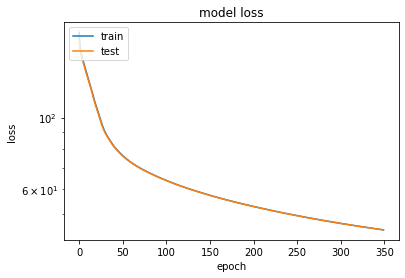

In [77]:
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
y_predict = NN_model2.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: -1.3459097267950382
RMSE: 2313498.578807041
MSE: 5352275674142.199
